In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import data_loaders.humanml.utils.paramUtil as paramUtil
from data_loaders.humanml.utils.plot_script import plot_3d_motion
from data_loaders.humanml.scripts.motion_process import recover_rot
from data_loaders.humanml.common.quaternion import cont6d_to_matrix,cont6d_to_matrix
from data_loaders.humanml.common.skeleton import Skeleton
from data_loaders.humanml.utils.paramUtil import *

def forward_kinematics_forcont6d_perframe(cont6d_params,root_pos,kinematic_tree,offsets,do_root_R=True):
    # cont6d_params shape should be [22,6]
    assert cont6d_params.shape == (22,6)
    assert root_pos.shape == (3,)
    # [:-1] means joints number 22, 最后一维替换成3 (xyz position) 最后结果是 [22,3]
    joints = torch.zeros(cont6d_params.shape[:-1] + (3,)).to(cont6d_params.device)
    # 将root position 写进 joints里面
    joints[0, :] = root_pos
    for chain in kinematic_tree:
        if do_root_R:
            # 30 196 22 6
            matR = cont6d_to_matrix(cont6d_params[0,:])
            # print('matR shape',matR.shape)
        else:
            matR = torch.eye(3).expand((len(cont6d_params), -1, -1)).detach().to(cont6d_params.device)
        # Start the calculate the rotation
        for i in range(1, len(chain)):
            # 从根关节到当前关节的旋转累计变换
            matR = torch.matmul(matR, cont6d_to_matrix(cont6d_params[chain[i],:]))
            # print('matR & cont6d_to_matrix', matR.shape, cont6d_to_matrix(cont6d_params[:, chain[i]]).shape)
            # 提取当前的offset
            offset_vec = offsets[:,chain[i]].unsqueeze(-1)
            # print('matR shape &offset_vec shape',matR.shape, offset_vec.shape)
            # 计算全局位置
            joints[chain[i],:] = torch.matmul(matR, offset_vec).squeeze(-1) + joints[chain[i-1],:]
            # print('joints[:, chain[i]]',joints[:, chain[i]].shape)

    return joints

r_pos torch.Size([30, 196, 3]) positions torch.Size([30, 196, 22, 3]) cont6d_params: torch.Size([30, 196, 22, 6])
positions torch.Size([30, 196, 22, 3])
motion torch.Size([196, 22, 3])


/home/lingfanb/miniconda3/envs/MDM/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/lingfanb/miniconda3/envs/MDM/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, n

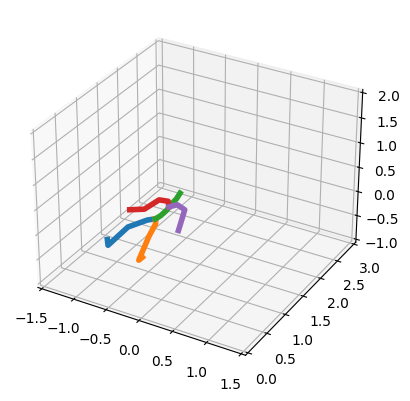

In [5]:
def main():
    # Extract Data from results.npy file 
    file_path = 'save/humanml_trans_enc_512/samples_humanml_trans_enc_512_000200000_seed10/results.npy'
    data = np.load(file_path,allow_pickle=True).item()
    all_rawData = data['raw_data']
    all_motions = data["motion"]
    all_lengths = data["lengths"]
    
    # Extract root position
    r_pos = all_motions[:,0,:,:]
    r_pos = torch.from_numpy(r_pos)
    r_pos = r_pos.permute(0, 2, 1)  # order: [batchsize, framelength, r_pos]
    # Extract cont6d data 
    cont6d_params = torch.from_numpy(all_rawData)

    # Define Skeleton offsets 
    n_raw_offsets = torch.from_numpy(t2m_raw_offsets)
    # 定义kinematic_chain 
    kinematic_chain = t2m_kinematic_chain
    skeleton = Skeleton(n_raw_offsets, kinematic_chain, 'cpu')

    # Get offsets of target skeleton    
    example_id = "000021"
    data_dir = './joints/'
    example_data = np.load(os.path.join(data_dir, example_id + '.npy'))
    example_data = example_data.reshape(len(example_data), -1, 3)
    example_data = torch.from_numpy(example_data)
    skeleton_offsets = skeleton.get_offsets_joints(example_data[0]).T

    # initialize the positions 
    positions = torch.zeros(all_motions.shape)
    positions = positions.permute(0, 3, 1, 2)
    print('r_pos', r_pos.shape, 'positions', positions.shape, 'cont6d_params:', cont6d_params.shape)

    # Get the positions, [0]: batch size, [1]: frame
    for batchsize in range(cont6d_params.shape[0]):
        for frame in range(cont6d_params.shape[1]):
            positions[batchsize,frame,:,:] = forward_kinematics_forcont6d_perframe(cont6d_params[batchsize,frame,:,:], r_pos[batchsize,frame,:], kinematic_chain, skeleton_offsets)
    # [30, 196, 22, 3]
    print('positions',positions.shape)

    length = 120
    # [196  22  3]
    motion = positions[1 + 1]
    print('motion', motion.shape)
    
    # plot the data for index 1;
    index = 120
    data = motion

    ax = plt.axes(projection='3d')
    radius = 3
    ax.set_xlim3d([-radius / 2, radius / 2])
    ax.set_ylim3d([0, radius])
    ax.set_zlim3d([-radius / 3., radius * 2 / 3.])

    skeleton_parent = t2m_kinematic_chain
    for i, (chain) in enumerate(skeleton_parent):
        if i < 5:
            linewidth = 4.0
        else:
            linewidth = 2.0
        ax.plot3D(data[index, chain, 0], data[index, chain, 1], data[index, chain, 2], linewidth=linewidth)

    plt.show()

if __name__ == "__main__":
    main()